> Changing the Classifier-Free Guidance parameter during diffusion.

In [ ]:
#| echo: False
import math
import latexify

# Introduction  
This notebook covers the results of dynamically changing the guidance parameter during Classifier-Free Guidance (CFG). Most notably, we create a `GuidanceTfm` class so that others may easily import these ideas and start experimenting.    


# Background 

We build on a great series of discussions on the [fast.ai forums](https://forums.fast.ai/) about Classifier-Free Guidance. Some of the users involved were: (please let me know if I missed anyone):  

- [FahimF](https://twitter.com/FahimFarook)  
- [Seb](https://twitter.com/sebderhy)  
- [Rekil](https://twitter.com/rekil_prashanth)  
- [Namrata](https://twitter.com/namrata_kamath)    
- [Jeremy](https://twitter.com/jeremyphoward)  
  
In these talks, two two ideas came up for better Guidance:  

- Normalizing the latents.  
- Scheduling the guidance scalar value.  

To see why these are good ideas, let's quickly recap how Classifier-free Guidance works.  

## Classifier-free Guidance overview

[Classifier-free Guidance](https://arxiv.org/abs/2207.12598) is a way of steering the outputs of Diffusion models to better align with a given input. It is a key aspect of how we are able to type in a text prompt and get back a relevant, generated image.  

CFG was needed because, by default, a Diffusion model starts from pure noise and randomly "walks" to unearth an image. Classifier-free Guidance can instead align the output according to a known, specific input. This known input is usually a meaningful piece of context like a sentence, or a segment of speech, or even another image.  

In summary: Instead of randomly walking to generate random images, CFG allows Diffusion models to create targeted outputs.  
   
### CFG Formula
CFG updates the unconditioned latents to better match the conditional inputs as follows: 

$$\hat{\epsilon}(x \ |\  y) = \epsilon(x) + G\left(\ \epsilon(x\  |\  y) - \epsilon(x)\ \right)$$  


We can think of this equation as a type of moving average. To be more specific, the terms are:    

**Equation Term** | **Description**
- | - 
$\epsilon(x)$ | Unconditioned noise prediction
$\epsilon(x\ |\ y)$ | Conditional noise prediction
$G$ | Guidance scaling factor
$\hat{\epsilon}(x\ |\ y)$ | The final, guided prediction.  


As several people have noticed, this update is not balanced. The reason for the unbalance is that $G$ is usually a large, fixed scalar. For example the default $G$ in Stable Diffusion pipelines is $G = 7.5$.   

This brings up two questions:  

- Does a large $G$ make the vectors too different?   
- Should $G$ be a fixed constant throughout the entire diffusion process?  

Fahim compiled the forum's answers to these questions in [this notebook](https://github.com/FahimF/fai-exp/blob/main/guidance_variations.ipynb). His work compares both different normalizations and schedules for the Guidance parameter.    

At first glance, it seems that both normalizing and scheduling the diffusion parameter improves the generated images. These better images are achieved for "free", in the sense that we didn't need any fine-tuning or new data.  

Let's take a look at some of the details and benefits of a dynamic guidance parameter.  

:::: {.callout-note}  
As [Ben Poole](https://twitter.com/poolio/status/1584699239342694402?s=20&t=DxGXG7GsU6uLFqUN55tHWw) points out in Jeremy's twitter thread, these ideas are not new on their own.  

One of the scalings was described in [Guided-TTS](https://arxiv.org/pdf/2205.15370.pdf) for Speech diffusion. The normalizations are also related to the ones in [Pretraining is All You Need for Image-to-Image
Translation](https://arxiv.org/pdf/2205.12952.pdf) by Wang et. al.  

Our normalizations are similar in spirit to the `Dynamic Thresholding` in the [Imagen paper](https://arxiv.org/abs/2205.11487).  
:::: 

## Normalizing the guidance

This notebook explores two types of normalization we call `BaseNorm` and `T-Norm`:  

- `BaseNorm`: Normalize the entire prediction by the ratio of the conditioned and unconditioned norms.  
$$\hat{\epsilon}(x \ |\  y)_\text{BaseNorm} = \hat{\epsilon}(x \ |\  y)\cdot \frac{\|\epsilon(x)\|}{\|\epsilon(x \ |\  y)\|}$$  

- `T-Norm`: Normalize the difference of the conditioned and unconditioned predictions.
$$\hat{\epsilon}(x \ |\  y)_\text{TNorm} = \epsilon(x) + G\ \frac{\epsilon(x \ |\  y) - \epsilon(x)}{\|\epsilon(x \ |\  y) - \epsilon(x)\|\cdot \|\epsilon(x)\|}$$  

## Scheduling the guidance  

In standard CFG the guidance scaling value is fixed. But since the final and initial images are so different, should we expect that the same value is optimal for the entire time?    

To explore this question we can borrow from Neural Network optimizers. Specifically, our idea of a "guidance schedule" is based on the popular schedules for learning rates.  

This notebook explores two new schedules for the CFG parameter $G$:  

- Cosine  
- Cosine with Warmup. 


## Combining the changes 

The natural idea is to combine these approaches: we should both normalize *and* schedule $G$.  

After exploring each change in isolation we combine them to see their joint effects. 

# Coding Setup

## Python imports  
First we import the python, PyTorch, and HuggingFace modules that we need. We also use the `timm` library for its built-in Cosine schedules.

In [ ]:
import os
import math
import random
import warnings
from PIL import Image
from typing import List
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from tqdm.auto import tqdm 

# imports for diffusion models
import torch
from transformers import logging
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

# use cosine scheduler from timm
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.optim import create_optimizer
from timm import create_model

# for clean outputs
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

# set the hardware device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu"

2022-11-20 19:51:47.940762: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Prompt for image generations

We use the following prompt to test our guidance changes:  

> "a photograph of an astronaut riding a horse"

This is the same prompt folks used in the forums. It seems like a good, simple starting point for future runs.  

In [ ]:
# the input prompt for diffusion
prompt = "a photograph of an astronaut riding a horse"

## Picking a Diffusion model  

We also have to pick a Diffusion model. Some possible options are:  

- `stable-Diffusion-v1-4` from CompVis.  
- `stable-Diffusion v1-5` from Runway.ml. 

Here we use the Stable Diffusion `v1-4` model from CompVis.  

But it is worth mentioning that this code will work with any Diffusion model name on the HuggingFace hub.  

In [ ]:
# set the diffusion model
model_name = "CompVis/stable-diffusion-v1-4" # "runwayml/stable-diffusion-v1-5"

## Utility functions.  

Next we define some helper functions.  

These helpers create the text embeddings, convert latent features into images, and plot the decoded images. All of these functions are directly from Fahim's notebook.

In [ ]:
def text_embeddings(prompts, maxlen=None):
    "Extracts text embeddings from the given `prompts`."
    maxlen = maxlen or tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0]


def image_from_latents(latents):
    "Scales the diffusion `latents` and turns them into a PIL Image."
    
    # scale and decode the latents
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        data = vae.decode(latents).sample[0]

    # Create PIL image
    data = (data / 2 + 0.5).clamp(0, 1)
    data = data.cpu().permute(1, 2, 0).float().numpy()
    data = (data * 255).round().astype("uint8")
    image = Image.fromarray(data)
    return image
    
    
def show_image(image, scale=0.5):
    "Displays the given `image` resized based on `scale`."
    img = image.resize(((int)(image.width * scale), (int)(image.height * scale)))
    display(img)
    return img


def image_grid(images, rows = 1, width=256, height=256, title=None):
    "Display an array of images in a nice grid, or single row"
    count = len(images)
    cols = int(count / rows)
    if cols * rows < count:
        rows += 1
    # Calculate fig size based on individual image sizes    
    px = 1/plt.rcParams['figure.dpi']
    w = cols * width * px
    # Add some extra space for the caption/title since that can wrap
    h = (rows * height * px) + (rows * 30 * px)
    fig, axes = plt.subplots(rows, cols, figsize=(w, h))
    for y in range(rows):
        for x in range(cols):
            index = y*cols + x
            ref = axes[x] if rows == 1 else axes[y] if cols == 1 else axes[y, x]
            ref.axis('off')
            if index > count - 1:
                continue
            img = images[index]
            txt = f'Frame: {index}'
            if title is not None:
                if isinstance(title, str):
                    txt = f'{title}: {index}'
                elif isinstance(title, List):
                    txt = title[index]
            # small change for bigger, more visible titles
            txt = '\n'.join(wrap(txt, width=70))
            ref.set_title(txt, fontsize='x-large')
            ref.imshow(img)
            ref.axis('off')
            

# Splitting the Diffusion pipeline.   

To test our hypotheses we need to change the parameter $G$ during diffusion.   

That means we need more control than what is available via HuggingFace's `pipeline` API.  

We can achieve this finer control by separately loading each piece of the Stable Diffusion pipeline. Then, we can use these pieces to write our own image generation loop. 

The function `get_sd_pieces()` returns the following pieces for a given Diffusion model:  

- Tokenizer. 
- Text Encoder.  
- Variational Auto-Encoder (VAE).  
- U-Net.  
- Sampler.  

> Note: We are using a different $\text{VAE}$ from `stability.ai` that was fine-tuned for more steps.  

In [ ]:
def get_sd_pieces(model_name, dtype=torch.float32):
    "Loads and returns the individual pieces in a Diffusion pipeline."
    
    # create the tokenizer and text encoder
    tokenizer = CLIPTokenizer.from_pretrained(
        model_name,
        subfolder="tokenizer",
        torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained(
        model_name,
        subfolder="text_encoder",
        torch_dtype=dtype).to(device)

    # we are using a VAE from stability that was trained for longer than the baseline 
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=dtype).to(device)
    ## NOTE: we can also use these vae from Stability that were trained for even longer
    #vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=dtype).to(device)
    
    # build the unet
    unet = UNet2DConditionModel.from_pretrained(
        model_name,
        subfolder="unet",
        torch_dtype=dtype).to(device)
    
    # enable unet attention slicing
    slice_size = unet.config.attention_head_dim // 2
    unet.set_attention_slice(slice_size)
        
    # build the scheduler
    scheduler = LMSDiscreteScheduler.from_config(model_name, subfolder="scheduler")
    
    return (
        tokenizer,
        text_encoder,
        vae,
        unet,
        scheduler,
    )


# load the individual diffusion pieces
pieces = get_sd_pieces(model_name, dtype=torch.float16)
(tokenizer, text_encoder, vae, unet, scheduler) = pieces

# Cosine schedules from `timm`   

We test two different schedules for $G$:  

- Cosine schedule.  
- Cosine with Warmup.  

The HuggingFace `pipeline` uses 50 diffusion timesteps by default. To keep things comparable, we also use 50 steps.    

The Cosine schedule starts from the default $G_\text{max} = 7.5$. It then slowly works down to a minimum of $G_\text{min} = 0.15$.  

We also make a schedule with Warmup. Warmup means that $G$ first starts low, then linearly works its way up to $G_\text{max}$. Only then does it start decreasing back down to $G_\text{min}$. As a starting point, we warmup during the first 10% of the Diffusion process (aka during the first 5 steps).  

For T-Norm, we use a slightly different Cosine schedule with smaller values. We need this because a large $G$ with T-Norm makes the problem we are trying to solve ($G$ too large) even worse. The smaller T-Norm values also align much better with how we typically think about mixing or moving averages.  

In [ ]:
# parameters for CFG cosine schedules
max_g = 7.5
min_g = 0.15
num_steps = 50

# warmup from the minimum over 10% of the process
warmup_ratio = 0.10  
warmup_start = min_g


# cosine schedule parameters
cos_params = {
    'max_val':         max_g,
    'num_steps':       num_steps,
    'min_val':         warmup_start,
    'warmup_fact':     0,
}

# warmup-cosine parameters
warmup_cos_params = {
    'max_val':         max_g,
    'warmup_start':    warmup_start,
    'num_steps':       num_steps,
    'min_val':         warmup_start,
    'warmup_init_val': warmup_start,
    'warmup_fact':     warmup_ratio,
}

# cosine schedule for T-Norm guidance
t_scale_params = {
    'max_val':         0.25,
    'num_steps':       num_steps,
    'min_val':         0.05,
}

We use the Cosine scheduler in `timm` for convenience.  

That means we need a bit of overhead code. Mainly, we need a dummy PyTorch optimizer and module.  

In [ ]:
# create dummy model
model = torch.nn.Linear(1, 1)

# arguments for the dummy optimizer
default_opt_args = {
    'opt':           'adam',
    'momentum':      1.0,
    'weight_decay':  0,
}


def get_cos_sched(**sched_params):
    """Creates a Cosine schedule using the `timm` library."""
    # number of diffusion iterations
    num_steps = sched_params['num_steps']
    
    min_val, max_val = sched_params['min_val'], sched_params['max_val']
    
    # compute number of warmup steps, if given
    if sched_params.get('warmup_fact'):
        warmup_t = int(num_steps * sched_params['warmup_fact'])
        warmup_init_val = sched_params.get('warmup_init_val', 0)
    else:
        warmup_t = warmup_init_val = 0
    
    # get the dummy optimizer for the timm scheduler
    opt_args = SimpleNamespace(lr=max_val, **default_opt_args)
    optimizer = create_optimizer(opt_args, model)
      
    # create the cosine schedule
    lr_sched = CosineLRScheduler(
        optimizer,
        t_initial=num_steps,
        lr_min=min_val,
        warmup_t=warmup_t,
        warmup_lr_init=warmup_init_val,
    )

    # extract and return the CFG values at each iteration
    cfg_per_step = [lr_sched.get_epoch_values(step)[0] for step in range(num_steps)]
    return cfg_per_step

Now that we have both the parameters and builder functions for Cosine schedules, we can create them:  

In [ ]:
# baseline cosine guidance schedule
cos_g = get_cos_sched(**cos_params)

# cosine schedule with warmup 
warmup_cos_g = get_cos_sched(**warmup_cos_params)

# cosine schedule with smaller G values for T-Norm
t_scale_cos_g = get_cos_sched(**t_scale_params)

## Plotting the Cosine schedules  

Let's plot these new schedules to compare them against the previous, constant guidance.  

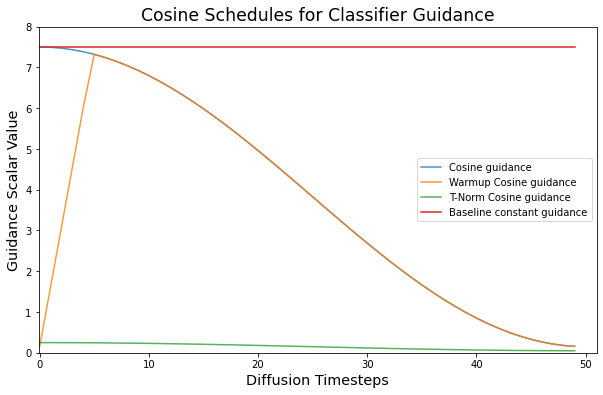

In [ ]:
#| echo: false
#| output: true
plt.figure(figsize=(10,6))
plt.title('Cosine Schedules for Classifier Guidance', fontsize='xx-large')
plt.xlabel('Diffusion Timesteps', fontsize='x-large')
plt.ylabel('Guidance Scalar Value', fontsize='x-large')
plt.xlim(-0.1, num_steps + 1)
plt.ylim(0, max_g + 0.5)
plt.plot([i for i in range(num_steps)], cos_g,             label="Cosine guidance", alpha=0.8);
plt.plot([i for i in range(num_steps)], warmup_cos_g,      label="Warmup Cosine guidance", alpha=0.8);
plt.plot([i for i in range(num_steps)], t_scale_cos_g,      label="T-Norm Cosine guidance", alpha=0.8);
plt.plot([i for i in range(num_steps)], [max_g]*num_steps, label="Baseline constant guidance")
plt.legend(loc='center right');

# The Guidance Transform class  

Here we create the Guidance Transformation class, `GuidanceTfm`. This class is heavily inspired by other [Transforms in the fast.ai library](https://fastai1.fast.ai/vision.transform.html).  

`GuidanceTfm` has an `encode()` method that takes the following inputs:  

**encode Argument** | **Description**
- | - 
$\epsilon(x)$ | Unconditioned latents
$\epsilon(x\ |\ y)$ | Conditional latents
$\text{idx}$ | The current diffusion step  


For convenience we call the unconditioned latents "$\text{u}$" and the conditioned latents "$\text{t}$".  

The base class applies a standard CFG update. However, there are also methods to pre and post process the latents. The goal of these other methods is to easily try different and custom normalizations. For example, we can implement all of our normalization ideas with these methods.

Lastly, `GuidanceTfm` takes one initialization parameter: `schedules`. This is a dictionary that maps a parameter name to an array-like, indexable sequence of values. This sequence is how we tap in to the scheduled $G$ value at timestep $\text{idx}$. And if we ever want to include or schedule other parameters, we can add them to `schedules` and access them in any of the `encode()` functions.    

In [ ]:
class GuidanceTfm:
    "Baseline Classifier-free Guidance for Difussion."
    name = "CFGuidance"
    def __init__(self, schedules, *args, **kwargs):
        self.schedules = schedules
        
    def encode(self, u, t, idx=None):
        "Applies guidance on `u` and `t` with optional pre/post processing."
        self.pre_proc(u, t, idx)
        self.guide(u, t, idx)
        self.post_proc(u, t, idx)
        return self.pred
    
    def guide(self, u, t, idx=None):
        "Mixes latents `u` and `t` based on guidance schedule for `g`."
        self.pred = u + (self.scheduler('g', idx) * (t - u))

    def pre_proc (self, u, t, idx=None): pass
    def post_proc(self, u, t, idx=None): pass
    
    def scheduler(self, name, idx):
        "Gets the scheduled value for parameter `name` at timestep `idx`."
        return self.schedules.get(name)[idx]
    
    
class BaseNormGuidance(GuidanceTfm):
    "Scales the noise prediction by its overall norm."
    name = "BaseNormGuidance"
    def post_proc(self, u, t, idx=None):
        self.pred = self.pred * (torch.linalg.norm(u) / torch.linalg.norm(self.pred))
        
        
class TNormGuidance(GuidanceTfm):
    "Scales the latent mix of `t - u`"
    name = "TNormGuidance"
    def guide(self, u, t, idx=None):
        self.pred = u + (self.scheduler('g', idx) * (t - u)) / torch.linalg.norm(t - u) * torch.linalg.norm(u)
        
        
class FullNormGuidance(TNormGuidance, BaseNormGuidance):
    "Applies both Base and T-Norm on the noise prediction."
    name = "FullNormGuidance"
    pass

# Creating guidance experiments  

Now that we have the transforms and schedules, we are finally ready to create some experiments!  

## Making `schedules ` for `GuidanceTfm`

We start with the following family of Guidance schedules:  
- Constant guidance with $\left(G = 7.5\right)$  
- Constant guidance with $\left(G = 0.15\right)$  
- A cosine schedule from $\left(G = 7.5\right)$ down to $\left(G = 0.15\right)$  
- A cosine schedule that warms up to $\left(G = 7.5\right)$ over the first 10% of steps    

For the T-Norm experiments, we also define a smaller-valued cosine schedule:  
- T-Norm cosine schedule from $\left(G = 0.25\right)$ down to $\left(G = 0.05\right)$  

The schedule maps below will be the arguments to our `GuidanceTfm` instances.  

In [ ]:
# baseline constant schedules with min and max values
max_sched        = {'g': [max_g] * num_steps}
min_sched        = {'g': [min_g] * num_steps}

# cosine schedules
cos_sched        = {'g': cos_g}
cos_warmup_sched = {'g': warmup_cos_g}

# normalized cosing schedules for T and Full-scale guidance
small_cos_sched = {'g':  t_scale_cos_g}

## Recreating the forum ideas  

First, let's recreate the experiment baselines from the forums and Fahim's notebook.  

In [ ]:
# stores the guidance experiements to run
expts = {}


### RECREATE SCALING RUNS FROM fast.ai FORUM POSTS
#################################################
#################################################
baseline        = GuidanceTfm(max_sched)       # 1) No scaling, guidance fixed to 7.5
scale_base_hi_g = BaseNormGuidance(max_sched)  # 2) Scale the "whole" update
scale_T_lo_g    = TNormGuidance(min_sched)     # 3) Scale the update of "t"
scale_all_hi_g  = FullNormGuidance(min_sched)  # 4) Scale everything (steps 2 + 3)

# add baselines to the experiment list
expts[f'NoNorm_FixedG_{max_g:.2f}']   = baseline
expts[f'BaseNorm_FixedG_{max_g:.2f}'] = scale_base_hi_g
expts[f'TNorm_FixedG_0{min_g:.2f}']   = scale_T_lo_g
expts[f'FullNorm_FixedG_{min_g:.2f}'] = scale_all_hi_g
#################################################

## Combining scales and schedules

Next, we leverage our `GuidanceTfm` class to easily make new experiments.  

We create the following:  

- Default and BaseNorm Guidance with Cosine and Cosine Warmup schedules. 
- T-Norm and FullNorm Guidance with the smaller T-Cosine schedule.  

In [ ]:
# group the cosine to run, and their names for plotting
name2sched = {
    'Cos':        cos_sched,
    'CosWarmup':  cos_warmup_sched,
    'TCos':       small_cos_sched,
}


# T-Norm and FullNorm guidance with small T-Cosine
norm_scalers = [TNormGuidance, FullNormGuidance]
for scaler in norm_scalers:
    
    # step through all cosine schedules
    for name in ['TCos']:

        # experiment for this (scaling, schedule) pair
        expt = scaler(name2sched[name])
        # unique name for this experiment
        expt_name = f'{scaler.name}_Sched_{name}'

        # add scaler to lists of experiments
        expts[expt_name] = expt

        
# Default and BaseNorm guidance with cosine schedules 
g_scalers = [GuidanceTfm, BaseNormGuidance]
for scaler in g_scalers:
    
    # step through all cosine schedules
    for name in ['Cos', 'CosWarmup']:

        # experiment for this (scaling, schedule) pair
        expt = scaler(name2sched[name])
        # unique name for this experiment
        expt_name = f'{scaler.name}_Sched_{name}'

        # add scaler to lists of experiments
        expts[expt_name] = expt

Here we print all of the queued experiments:

In [ ]:
print("Guidance experiments to run:\n")
print('\n'.join(f'{k}' for k,_ in expts.items()))

Guidance experiments to run:

NoNorm_FixedG_7.50
BaseNorm_FixedG_7.50
TNorm_FixedG_00.15
FullNorm_FixedG_0.15
TNormGuidance_Sched_TCos
FullNormGuidance_Sched_TCos
CFGuidance_Sched_Cos
CFGuidance_Sched_CosWarmup
BaseNormGuidance_Sched_Cos
BaseNormGuidance_Sched_CosWarmup


# Generating images

We are almost there! Now we need a way to actually generate images.  


The `generate()` function below is almost identical to the the `StableDiffusionPipeline()` from HuggingFace. 

We make a few changes to ensure that the initial latents are the same between runs. That means that only the guidance schedule and/or normalization affects the outputs.  

In [ ]:
# create the shared, initial latents
width, height = 512, 512

# grab the initial set of latents
seed = 1024
torch.manual_seed(seed)
init_latents = torch.randn((1, unet.in_channels, height//8, width//8), dtype=unet.dtype, device=device)

def generate(prompt, gtfm=None, width=width, height=height, guidance=max_g, steps=num_steps, **kwargs):
    # make sure we got a guidance function
    assert gtfm
    
    # prepare text embeddings
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text]).type(unet.dtype)
    
    # start from the shared, initial latents
    latents = torch.clone(init_latents)
    scheduler.set_timesteps(steps)
    latents = latents * scheduler.init_noise_sigma
    
    # run diffusion
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
            u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        
        # run the guidance transform
        pred = gtfm.encode(u, t, idx=i)
        
        # update the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
    # decode and return the final latents
    image = image_from_latents(latents)
    return image    

Let's save ourselves some work by writing a harness function to automatically store the experiment results:

In [ ]:
# store generated images and their title (the experiment name)
images, titles = [], []

def harness(prompt, gtfm, title=''):
    img = generate(prompt, gtfm)
    #print(title)
    #show_image(img, scale=1)
    images.append(img)
    titles.append(title)

# Running the guidance experiments.  

In [ ]:
# run each of the functions with the harness
for gname, gtfm in expts.items():
    print(f'Running experiment: {gname}...')
    harness(prompt, gtfm, title=gname)
    print('Done.')

Running experiment: NoNorm_FixedG_7.50...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: BaseNorm_FixedG_7.50...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: TNorm_FixedG_00.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: FullNorm_FixedG_0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: TNormGuidance_Sched_TCos...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: FullNormGuidance_Sched_TCos...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: CFGuidance_Sched_Cos...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: CFGuidance_Sched_CosWarmup...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: BaseNormGuidance_Sched_Cos...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running experiment: BaseNormGuidance_Sched_CosWarmup...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


# Results

## Showing all images side by side  

Our starting image, the baseline, is in the top-left. All other images are from different Guidance normalizations and schedules.

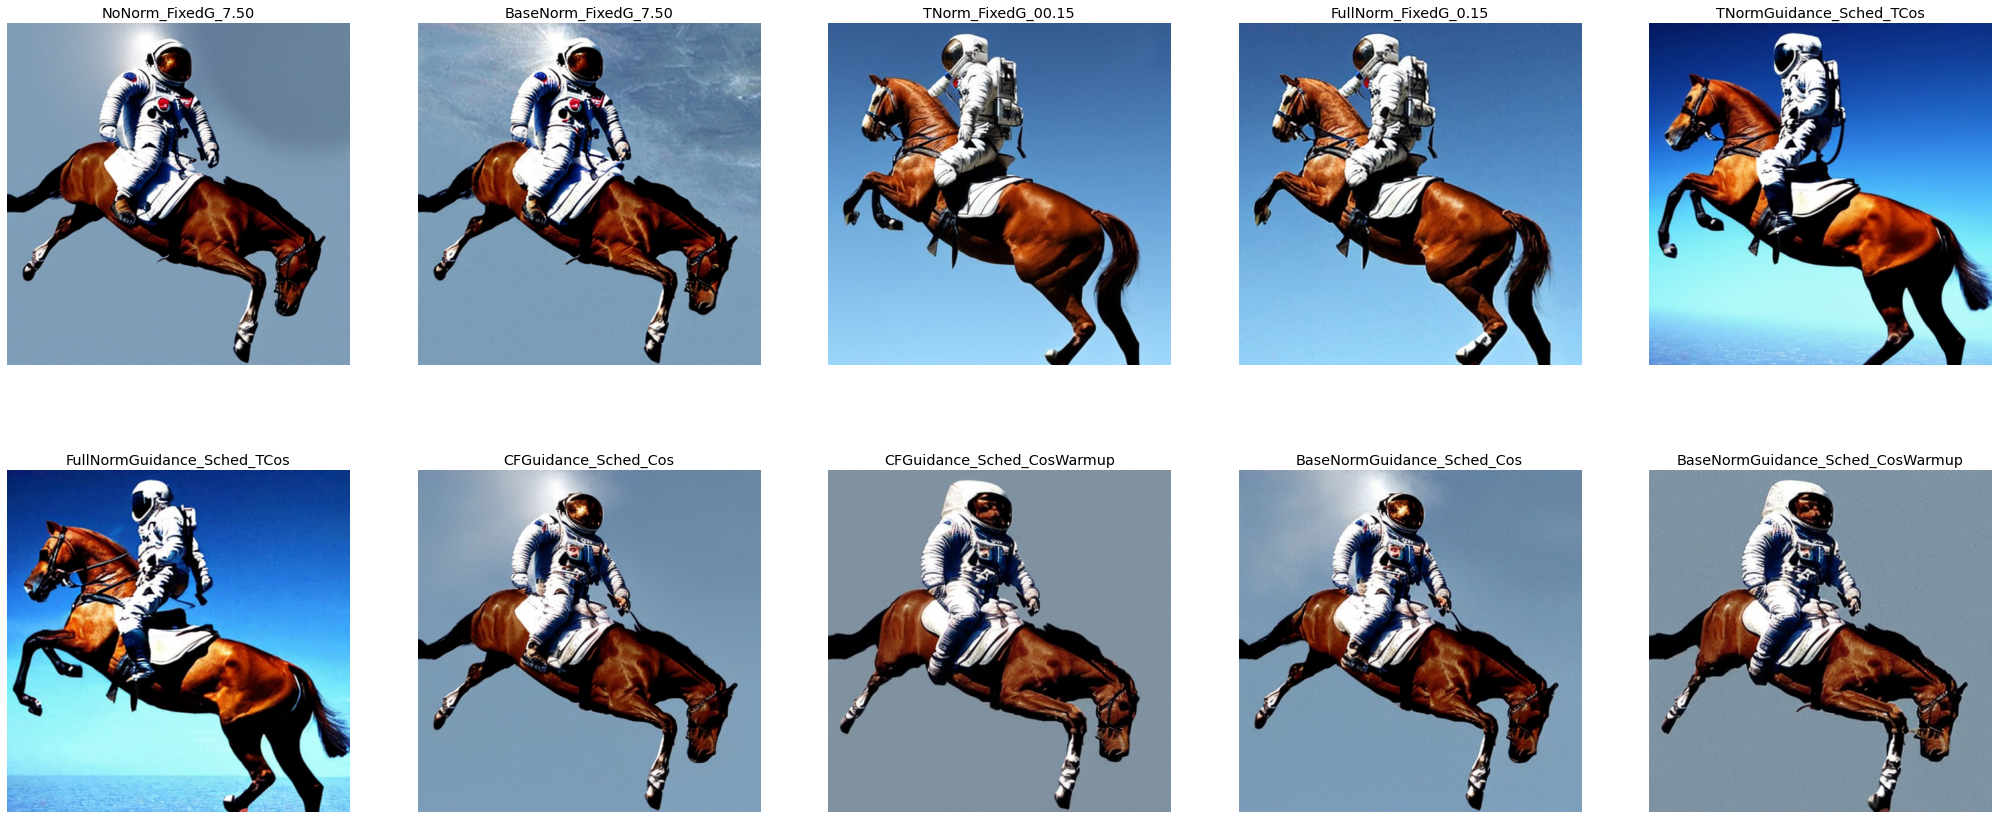

In [ ]:
#| echo: false
#| output: true
# display all images
image_grid(images, title=titles, rows=2, width=width, height=height)

That's a lot of images. Thankfully, there is one result that stands out above the rest: 

## Biggest Improvement: Cosine with T-Norm and FullNorm

There seems to be a consistent gain from using either T-Norm or FullNorm with a Cosine schedule.  

The image below compares our baseline to T-Norm and Cosine schedule. We can see:

- A more semantically correct horse (it has all of its legs!).  
- Better details and colors in the background. 

The horse's body is still not quite right, but it's a marked improvement from the baseline.  

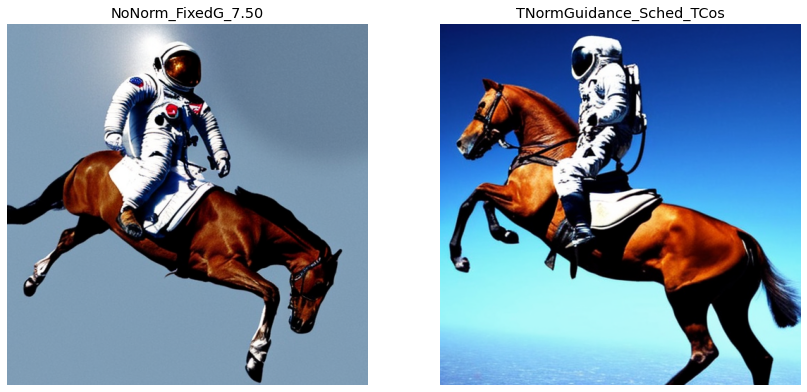

In [ ]:
#| echo: false
#| output: true
image_grid([images[0], images[4]], title=[titles[0], titles[4]], rows=1, width=width, height=height)

## Cosine T-Norm vs. Cosine FullNorm  

These images are close, and both are better than the baseline. It seems we traded some background quality for subject quality with FullNorm vs. T-Norm. 

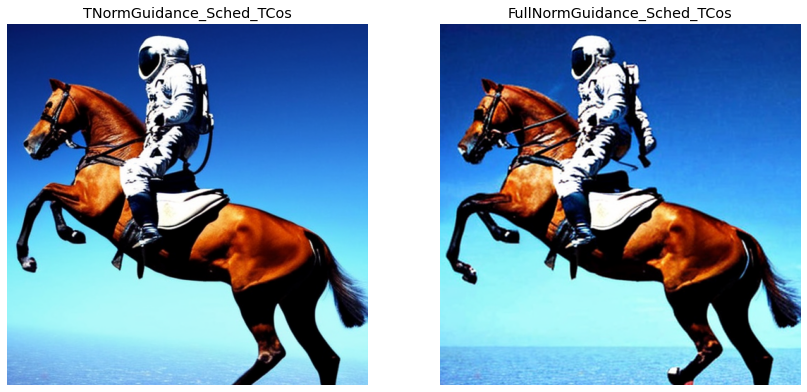

In [ ]:
#| echo: false
#| output: true
image_grid([images[4], images[5]], title=[titles[4],titles[5]], rows=1, width=width, height=height)

# Conclusion

This notebook recaps a set of discussions on the fast.ai forums about how to improve Classifier-free Guidance.

Two changes were proposed and tested:  
- Normalizing the guidance parameter.  
- Scheduling the guidance parameter.  

A `GuidanceTfm` class was created to easily leverage these approaches in other runs.  

Overall, it seems that a combination of T-Norm and Cosine schedule improves both the details and syntax of generated images.  

Given that these improvements are achieved for "free", with a negligible increase in computation time, and without any external data or fine-tuning, they could be a healthy addition to any existing diffusion process.  

### More examples  

Here is an example from a run using a different prompt:  

> "a portrait of a great Incan Warlord wearing his ornate ceremonial armor"  


With a few Diffusion pipeline changes:  

- Using Stable Diffusion `v1-5` from Runway.ml  
- Using $\text{VAE-mse}$ from stability.ai   

We again see a huge improvement from using FullNorm with a Cosine schedule.  

  
**Baseline** | **FullNorm with Cosine schedule**
:- | :- 
![](static/imgs/comp1.png) | ![](static/imgs/comp2.png)  
  
  

This shows that the improvements may not be isolated to `v1-4` or any particular $VAE$!

# Appendix: More comparisons  

The gains from other schedules are normalizations are less noticeable.   

There are likely still universal gains from normalizing. But with Cosine schedules on their own the results are more mixed.    

To drive this point home: there is a lot more exploration left to do for both schedule values and warmups. This notebook is hopefully a good starting point for others to build on!  

## Original vs. BaseNorm 

Here we plot our default image and the result from BaseNorm.  

The differences are subtle, but track the general observations from the forums:  
- More detail in the backgrounds.  
- Better shadowing on subjects.  
- Some moderate clarity gains.  

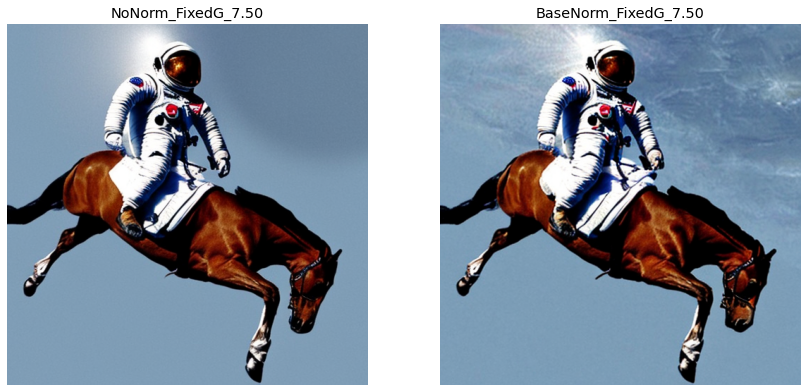

In [ ]:
#| echo: false
#| output: true
image_grid([images[0], images[1]], title=[titles[0],titles[1]], rows=1, width=width, height=height)

## Original vs. T-Norm

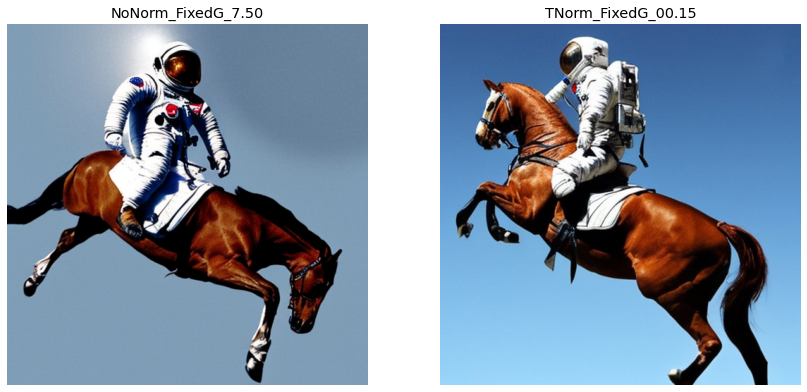

In [ ]:
#| echo: false
#| output: true
image_grid([images[0], images[2]], title=[titles[0],titles[2]], rows=1, width=width, height=height)

## Original vs. FullNorm

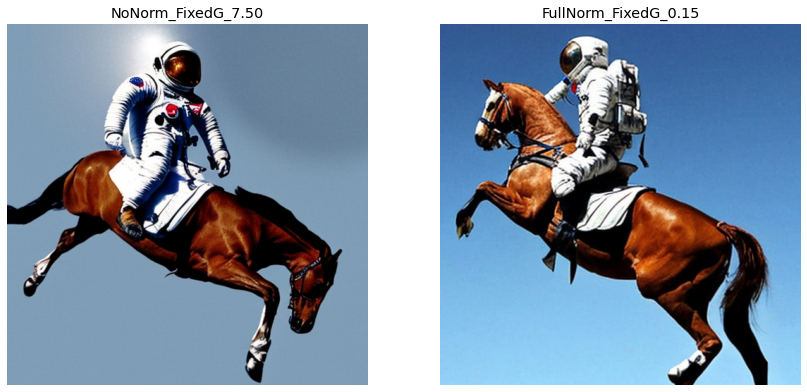

In [ ]:
#| echo: false
#| output: true
image_grid([images[0], images[3]], title=[titles[0],titles[3]], rows=1, width=width, height=height)

## Original vs. Cosine

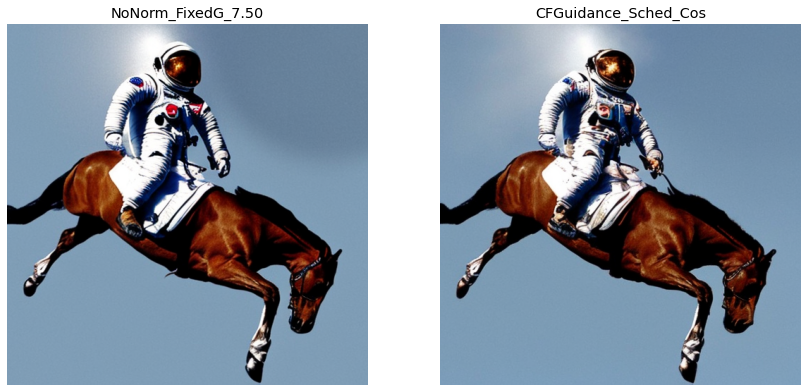

In [ ]:
#| echo: false
#| output: true
image_grid([images[0], images[6]], title=[titles[0],titles[6]], rows=1, width=width, height=height)

## Original vs. BaseNorm with Cosine

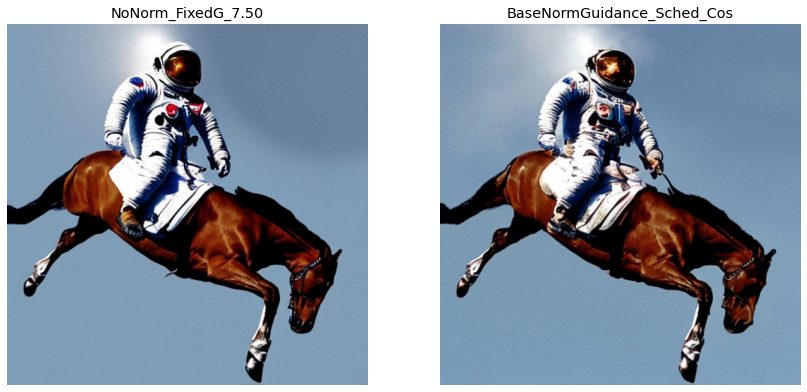

In [ ]:
#| echo: false
#| output: true
image_grid([images[0], images[8]], title=[titles[0],titles[8]], rows=1, width=width, height=height)